# Analyze pollen grains using Points

By Jorge Gutierrez

In this notebook we analyze pollen grain images. A portion of the grains can be detected automatically using a color threshold and filtering the objects according to eccentricity. Then visualize.ClickCount can be used to adjust the detections and manually select the germinated grains.


## Import libraries and define local functions

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from plantcv import plantcv as pcv

In [2]:
# Input/output options
class options:
    def __init__(self):
        self.image = "./data/example.jpg"  # required
        self.debug = None  # None, "print" (save to file), or "plot" (display in notebook)
        self.writeimg= False
        self.result = "example.json"  # required
        self.outdir = "./results" # Store the output to the current directory 

# Get options
args = options()

In [3]:
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 120
pcv.params.text_size = 10

## Load image and threshold 
The channel used and the threshold value can be adjusted for a better result. The resulting binary image from this step must contain all the grains. The tubes will be removed in the next step

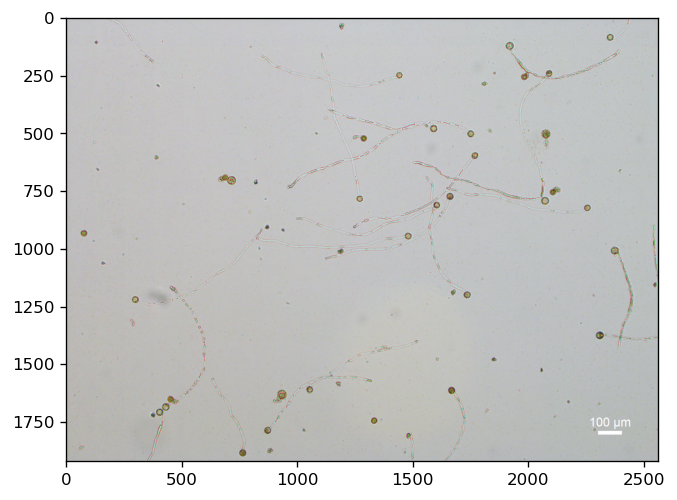

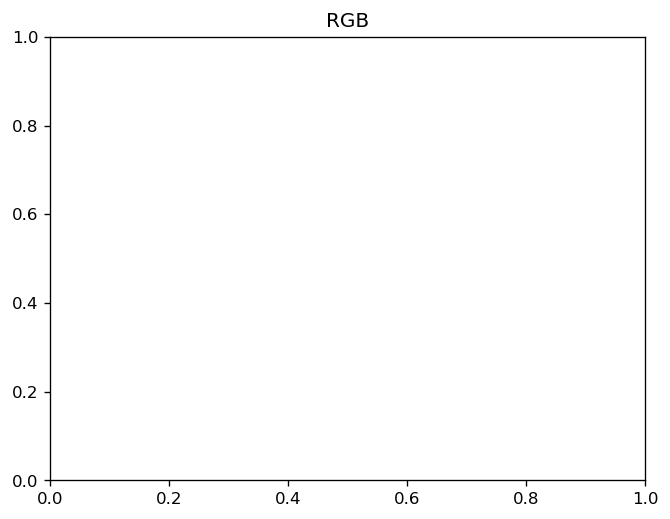

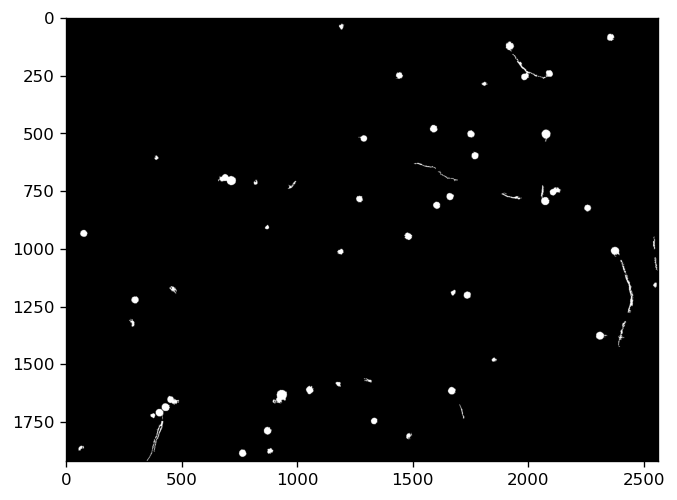

Text(0.5, 1.0, 'Binary image containing all the grains')

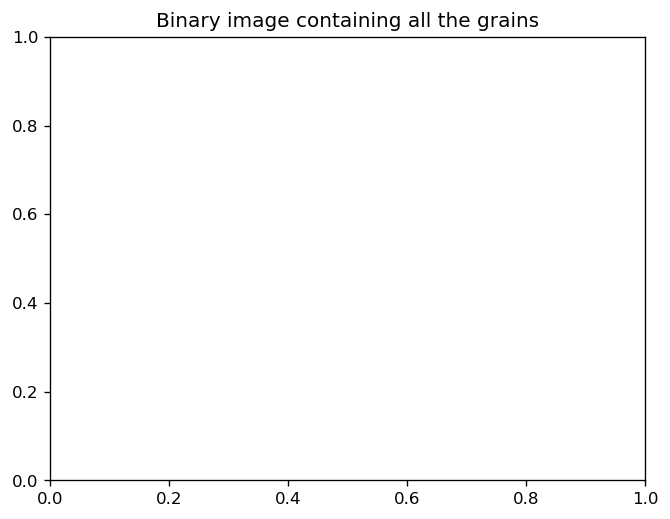

In [4]:
img, _, fname = pcv.readimage(filename=args.image, mode="native")
h,w,_ = img.shape

pcv.plot_image(img)
plt.title('RGB')

img_B = img[:,:,0]
#pcv.plot_image(img_B)
#plt.title('B channel')

# threshold for the blue channel to adjust for the image
th_B = 150
img_B_thresh = img_B < th_B
#pcv.plot_image(img_B_thresh)
#plt.title('B threshold')

# post-processing for cleaning
img_B_post = pcv.fill_holes(img_B_thresh)
img_B_post = pcv.fill(img_B_post, 210)
pcv.plot_image(img_B_post)
plt.title('Binary image containing all the grains')

## Discard objects that are not circular
Adjust the eccentricity threshold. A value closer to 0 is more strict about the circular form. 
This step is supposed to eliminate the tubes and automatically detect most of the grains. Some grains will be eliminated as well and will have to be selected manually in the next step.

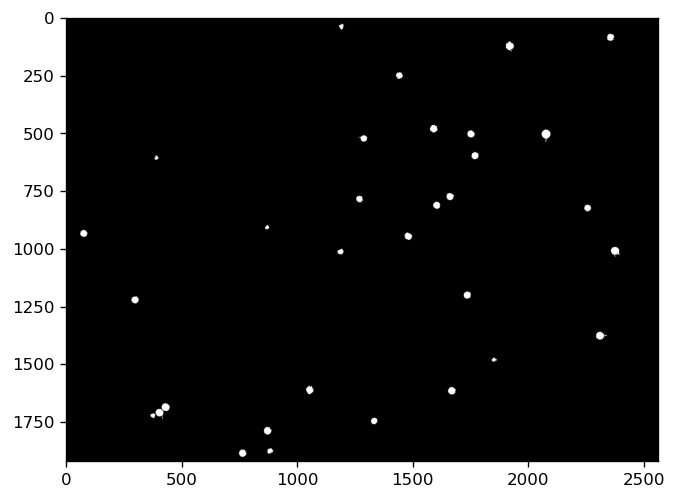

Text(0.5, 1.0, 'Binary mask after eliminating the tails')

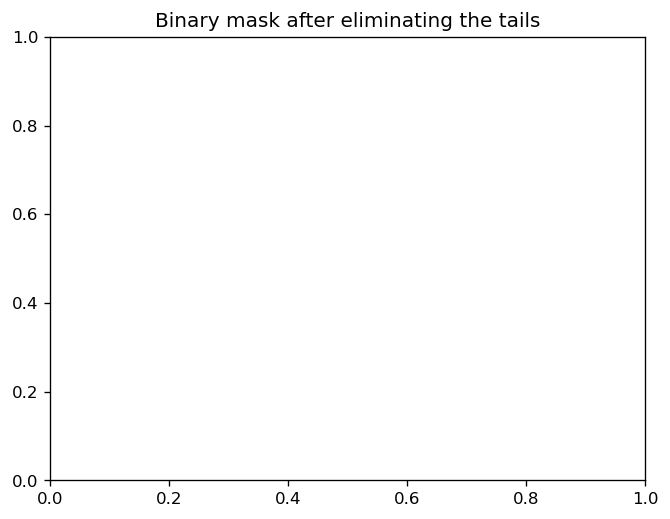

In [5]:
discs = pcv.filters.eccentricity(img_B_post, ecc_thresh=0.65)
pcv.plot_image(discs)
plt.title('Binary mask after eliminating the tails')

## Initialize interactive tool and import pre-detected grains
Click to select missing grains and to fix bad detections. Adjust figsize for zoom,

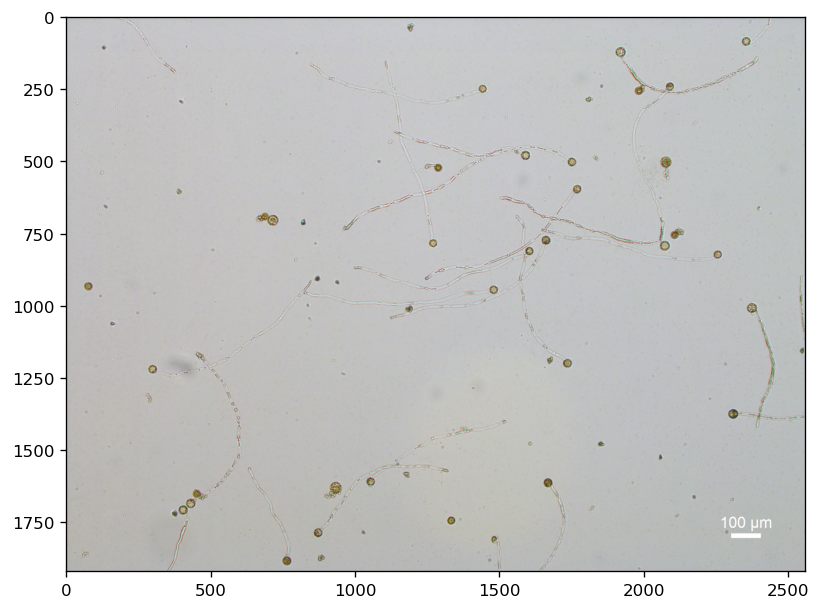

In [6]:
# initialization
marker = pcv.Points(img, figsize=(8, 6))

In [7]:
if (len(marker.points) < 1):
    marker.points = [(1446, 247), (1588, 484), (1748, 500), (1772, 604)]
len(marker.points)

4

## View number of selected points

In [8]:
print(f"There are {len(marker.points)} selected objects")

There are 4 selected objects


## Next Steps

Sometimes you may only be collecting counts, in which case you might write out results before other downstream steps. If you want more information then you may continue using the clicked points to make ROIs and continue with PlantCV. See the stomata tutorial and others for possible directions.

In [9]:
# use marker.points as ROI centers
roi = pcv.roi.multi(img=img, coord=marker.points, radius=15)
# make mask
img_l = pcv.rgb2gray_lab(rgb_img=img, channel='l')
# Threshold the l channel image to get only the pollen
#If you don't like this threshold, you can try the other channels (a, l, v, s)
mask = pcv.threshold.binary(gray_img=img_l, threshold=135, object_type='dark')
# fill in holes
cross_kernel = pcv.get_kernel(size=(18,18), shape = "ellipse")
filled_mask = pcv.closing(gray_img=mask, kernel = cross_kernel)
# make labels 
labeled_objects, n_obj = pcv.create_labels(mask=filled_mask, rois=roi, roi_type="partial")
# analyze size
analysis_image = pcv.analyze.size(img=img, labeled_mask=labeled_objects, n_labels=n_obj)

In [10]:
# Save results as json
pcv.outputs.save_results(filename=args.result)